# SHAP - "exact" calculation

- [Online Course](https://www.trainindata.com/p/machine-learning-interpretability)

In this notebook, we'll use the "exact" calculation of SHAP values. Check out the theory video to understand how this calculation of SHAP values work.

This approximation is possible only with datasets with few features.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from treeinterpreter import treeinterpreter as ti

import shap

## Load data

In [2]:
# load the California House price data from Scikit-learn
X, y = fetch_california_housing(return_X_y=True, as_frame=True)
X.drop(["Longitude", "Latitude"], axis=1, inplace=True)

# display top 5 rows
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467


In [3]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((14448, 6), (6192, 6))

## Train Random Forest

In [4]:
# the model we want to interpret
rf = RandomForestRegressor(n_estimators=50, max_depth=3, random_state=0)

# train model with all features
rf.fit(X_train, y_train)

print(f"model performance; {rf.score(X_test, y_test)}")

model performance; 0.5408409066892486


## Global importance

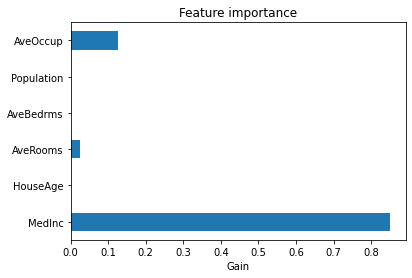

In [5]:
# global importance

imp = pd.Series(rf.feature_importances_, index=rf.feature_names_in_)
imp.plot.barh()
plt.xlabel("Gain")
plt.title("Feature importance")
plt.show()

## local interpretability

In [6]:
# interpret feature contribution of first 5 predictions

prediction, bias, contributions = ti.predict(rf, X_test)

contributions = pd.DataFrame(contributions, columns=X.columns)

contributions.head()

C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\Sole\Docume

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup
0,0.008982,0.0,0.000000,0.0,0.0,-0.203937
1,0.946790,0.0,0.000000,0.0,0.0,-0.299274
2,0.008982,0.0,0.000000,0.0,0.0,-0.203937
3,-0.736763,0.0,-0.151751,0.0,0.0,-0.009141
4,0.257889,0.0,0.000000,0.0,0.0,0.695506


We see that Population, HouseAge and AvBdrms add nothing to the house price.

In [7]:
bias[0]

2.067211550249157

## SHAP - exact values

### From the main explainer

In [8]:
# set up the explainer
# selects exact (random permutations) automatically
#  when there are less than 10 features

explainer = shap.Explainer(rf.predict, X_train)

# you can also speficy it like this:
# explainer = shap.Explainer(rf.predict, X_train, algorithm="exact")

In [9]:
# corroborate that it selected the exact explainer

explainer.__class__

shap.explainers._exact.ExactExplainer

In [10]:
# obtain the shap values

shap_values = explainer(X_test.head(5))

shap_values

.values =
array([[-2.24796052e-02, -2.53748028e-04, -2.71938123e-02,
        -9.71445147e-17,  4.16333634e-17, -1.35747091e-01],
       [ 8.93985195e-01,  6.65837704e-04, -2.71938123e-02,
        -5.55111512e-17,  0.00000000e+00, -2.10661141e-01],
       [-2.43913883e-02,  6.65837704e-04, -2.71938123e-02,
        -4.16333634e-17, -1.38777878e-17, -1.34754894e-01],
       [-7.76809234e-01,  6.65837704e-04, -5.85792603e-02,
         2.08166817e-17, -3.46944695e-17, -5.36517809e-02],
       [ 3.90419729e-01, -2.53748028e-04, -2.22670290e-02,
        -1.52655666e-16, -1.38777878e-17,  5.94776560e-01]])

.base_values =
array([2.05793108, 2.05793108, 2.05793108, 2.05793108, 2.05793108])

.data =
array([[4.15180000e+00, 2.20000000e+01, 5.66307278e+00, 1.07547170e+00,
        1.55100000e+03, 4.18059299e+00],
       [5.77960000e+00, 3.20000000e+01, 6.10722611e+00, 9.27738928e-01,
        1.29600000e+03, 3.02097902e+00],
       [4.34870000e+00, 2.90000000e+01, 5.93071161e+00, 1.02621723e+00,
   

As you can see, these calculation takes a while, and we are only explaining 5 observations with 6 features. So it is easy to see how this methods does not scale much further.

### Setting a specific explainer

In [11]:
explainer = shap.ExactExplainer(rf.predict, X_train)

In [12]:
shap_values = explainer(X_test)

shap_values

ExactExplainer explainer: 6193it [02:26, 39.27it/s]                                                                    


.values =
array([[-2.24796052e-02, -2.53748028e-04, -2.71938123e-02,
        -9.71445147e-17,  4.16333634e-17, -1.35747091e-01],
       [ 8.93985195e-01,  6.65837704e-04, -2.71938123e-02,
        -5.55111512e-17,  0.00000000e+00, -2.10661141e-01],
       [-2.43913883e-02,  6.65837704e-04, -2.71938123e-02,
        -4.16333634e-17, -1.38777878e-17, -1.34754894e-01],
       ...,
       [ 2.31116873e+00,  1.26882573e-02, -2.71938123e-02,
        -2.77555756e-17,  2.77555756e-17,  3.68015024e-03],
       [-7.67390271e-01,  6.65837704e-04, -5.85792603e-02,
        -9.02056208e-17,  2.08166817e-17, -6.30707441e-02],
       [-1.04028587e-02,  6.65837704e-04, -2.71938123e-02,
        -5.55111512e-17,  0.00000000e+00, -1.31883282e-01]])

.base_values =
array([2.05793108, 2.05793108, 2.05793108, ..., 2.05793108, 2.05793108,
       2.05793108])

.data =
array([[4.15180000e+00, 2.20000000e+01, 5.66307278e+00, 1.07547170e+00,
        1.55100000e+03, 4.18059299e+00],
       [5.77960000e+00, 3.2000000

Now that we are modelling the entire test set, you see how much longer the calculations take.

### Global explanations

With beeswarm plots we can see the range of impact of each feature on the target value. It's an idea of global importance.

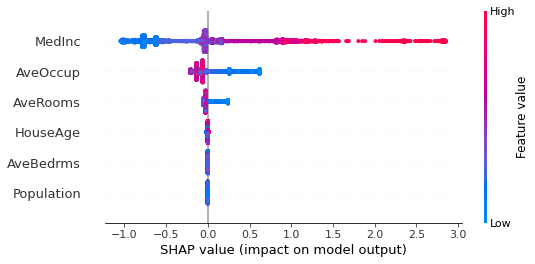

In [13]:
shap.plots.beeswarm(shap_values)

- The larger the SHAP value range, the more important the feature.
- The color indicates the feature magnitude

- Big values of MedInc, increase the house price a lot. 
- Small values of MedInc, decrease the house price.


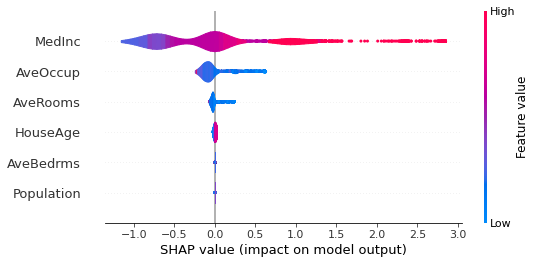

In [14]:
shap.plots.violin(shap_values)

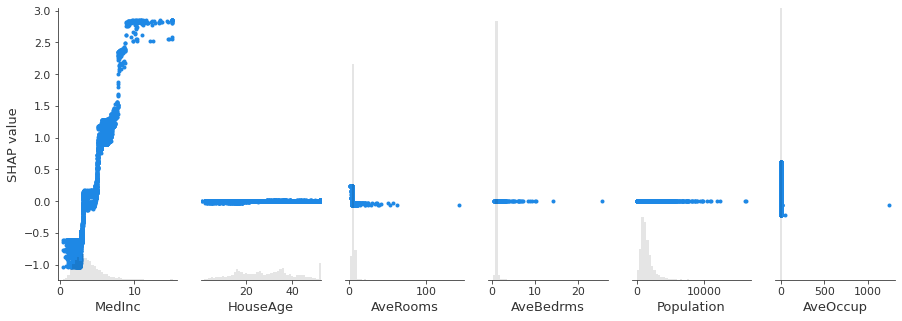

In [15]:
shap.plots.scatter(shap_values)

### Local explanations

We'll now make waterfall plots for specific samples.

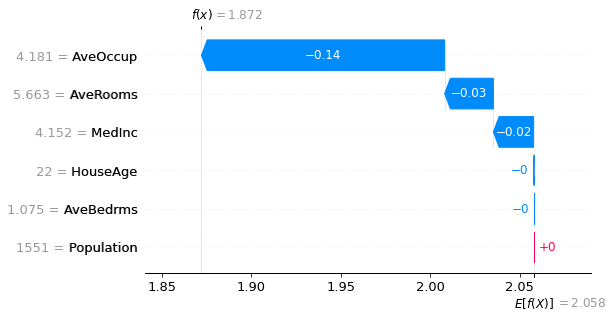

In [16]:
shap.plots.waterfall(shap_values[0], max_display=14)

The waterfall plot starts at the expectation without features (mean of the target) and shows how each feature moves the price away (up or down) respect to the origin.

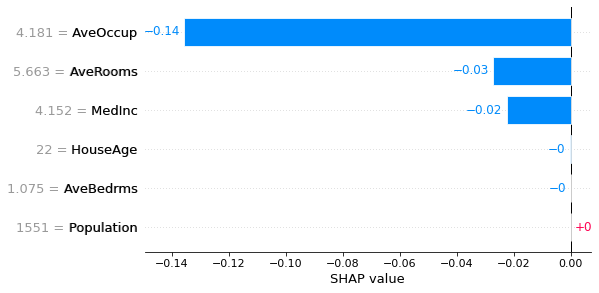

In [17]:
shap.plots.bar(shap_values[0], max_display=14)

The bar plot shows how each feature modifies the house price, irrespective of the origin (target mean).

In [18]:
# for comparison, let's display the tree interpreter explanations

pd.DataFrame(contributions, columns=X.columns).loc[0]

MedInc        0.008982
HouseAge      0.000000
AveRooms      0.000000
AveBedrms     0.000000
Population    0.000000
AveOccup     -0.203937
Name: 0, dtype: float64

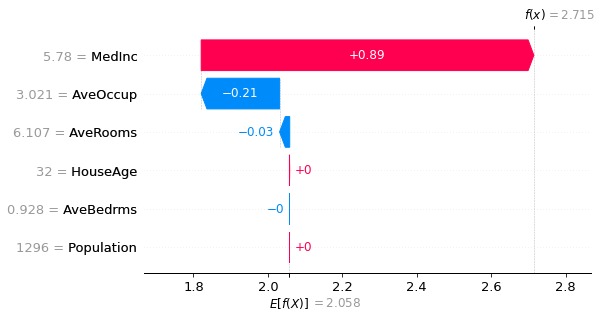

In [19]:
shap.plots.waterfall(shap_values[1], max_display=14)

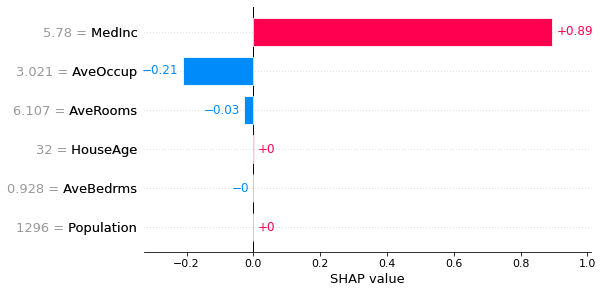

In [20]:
shap.plots.bar(shap_values[1], max_display=14)

In [21]:
# for comparison, let's display the tree interpreter explanations

pd.DataFrame(contributions, columns=X.columns).loc[14]

MedInc        0.008982
HouseAge      0.000000
AveRooms      0.000000
AveBedrms     0.000000
Population    0.000000
AveOccup     -0.203937
Name: 14, dtype: float64

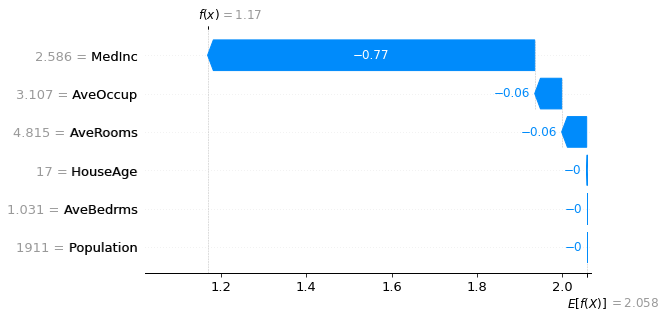

In [19]:
shap.plots.waterfall(shap_values[20], max_display=14)

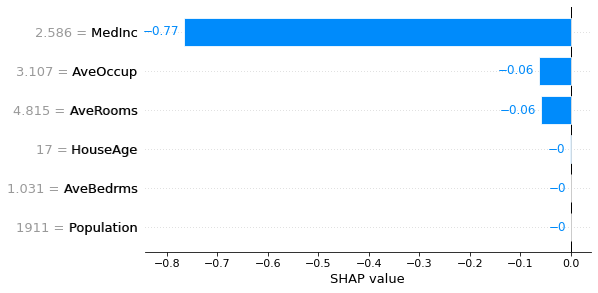

In [22]:
shap.plots.bar(shap_values[20], max_display=14)

In [20]:
# for comparison, let's display the tree interpreter explanations

contributions.loc[20]

MedInc       -0.736763
HouseAge      0.000000
AveRooms     -0.151751
AveBedrms     0.000000
Population    0.000000
AveOccup     -0.009141
Name: 20, dtype: float64

## Partial dependence plots

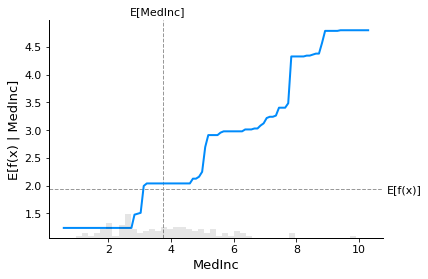

In [24]:
X100 = shap.utils.sample(X, 100)  # 100 instances for use as the background distribution

shap.partial_dependence_plot(
    "MedInc",
    rf.predict,
    X100,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

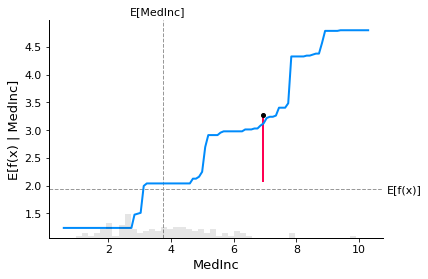

In [27]:
# make a standard partial dependence plot
sample_ind = 800
shap.partial_dependence_plot(
    "MedInc",
    rf.predict,
    X100,
    model_expected_value=True,
    feature_expected_value=True,
    ice=False,
    shap_values=shap_values[sample_ind : sample_ind + 1, :],
)